# Evaluate Anomaly Detection Models

- Evaluate anomaly detection models discussed in this paper: https://arxiv.org/pdf/2501.04819

1. Transformer models (linear, convolutional, convolutional with skip connections, convolutional with skip connections and transformer)
2. Isolation forest
3. One class SVM

The convolutional with skip connections and transformer achieves the best performance.

The code is adopted from this reference: https://github.com/AnthonyDeschenes/PlaningItByEarDataset/tree/main


In [1]:
import os

import matplotlib
import numpy as np
import torch
import torch.nn.functional as F
import joblib
from joblib import dump, load
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve
from sklearn.svm import OneClassSVM
import random

from models.AutoEncoder import AutoEncoder
from models.ConvolutionalAutoEncoder import ConvolutionalAutoEncoder
from models.ConvolutionalAutoEncoderWithSkip import ConvolutionalAutoEncoderWithSkip
from models.ConvolutionalAutoEncoderWithSkipAndTransformer import ConvolutionalAutoEncoderWithSkipAndTransformer
from trainer.dataloader import CustomDataset
from trainer.trainer import ModelTrainer

# Change this value to True to train the models and to False to evaluate the models on the evaluation dataset and
# generate the ROC curves
train = False

seed_value = 1986
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

v_transformer_cae = ModelTrainer(num_input=401, batch_size=32,
                                 num_input_channels=80,
                                 name=f"cae-transformer",
                                 network_class=ConvolutionalAutoEncoderWithSkipAndTransformer,
                                 lr=1e-3,
                                 loss=F.mse_loss)

v_skip_cae = ModelTrainer(num_input=401, batch_size=32,
                          num_input_channels=80,
                          name=f"skip-cae",
                          network_class=ConvolutionalAutoEncoderWithSkip,
                          lr=1e-3,
                          loss=F.mse_loss)

v_cae = ModelTrainer(num_input=401, batch_size=32,
                     num_input_channels=80,
                     name=f"cae-duman",
                     network_class=ConvolutionalAutoEncoder, lr=1e-3,
                     loss=F.mse_loss)

v_ae = ModelTrainer(num_input=401, batch_size=32,
                    num_input_channels=80,
                    name=f"ae-DCASE",
                    network_class=AutoEncoder, lr=1e-3,
                    loss=F.mse_loss)

if train:
    d = CustomDataset([
        "data/training/2x3/",
        "data/training/2x4/",
        "data/training/2x6/",
        "data/training/machine_start_stop/"
    ])
else:
    d = CustomDataset([
        "data/evaluation/normal/",
    ])

d_anomalies = CustomDataset([
    "data/evaluation/anomalies/broken_board/",
    "data/evaluation/anomalies/board_stuck/",
    "data/evaluation/anomalies/Uneven_thick_wood/",
])

print(len(d))
y_true = np.zeros(len(d))
y_true_anomalies = np.ones(len(d_anomalies))

y_true = np.concatenate((y_true, y_true_anomalies))


val_size = int(0.1 * len(d))
train_set, val_set = torch.utils.data.random_split(d, [len(d) - val_size, val_size])

print("Transformer")
v_transformer_cae.train(train_set, val_set)
print("AE")
v_ae.train(train_set, val_set)
print("CAE")
v_cae.train(train_set, val_set)
print("CAE skip")
v_skip_cae.train(train_set, val_set)

if not os.path.exists(os.path.join(os.path.abspath(''), f'one_class_svm_{model_name}.joblib')):
    oneclass_svm = OneClassSVM(gamma='auto').fit(d[[i for i in range(len(d))]].reshape(-1, 80 * 401))
    dump(oneclass_svm, os.path.join(os.path.abspath(''), f'one_class_svm_{model_name}.joblib'))
else:
    oneclass_svm = load(os.path.join(os.path.abspath(''), f'one_class_svm_{model_name}.joblib'))
print('one class svm done...')

if not os.path.exists(os.path.join(os.path.abspath(''), f'isolation_forest.joblib')):
    isolation_forest = IsolationForest(random_state=seed_value).fit(d[[i for i in range(len(d))]].reshape(-1, 80 * 401))
    dump(isolation_forest, os.path.join(os.path.abspath(''), f'isolation_forest.joblib'))
else:
    isolation_forest = load(os.path.join(os.path.abspath(''), f'isolation_forest.joblib'))
print('isolation forest done...')
    
if not train:
    datas = []
    isolation_forest_scores = []
    one_class_scores = []
    print("Scoring normal data")
    for i, data in enumerate(d):
        if i % 100 == 0:
            print(i, "/", len(d))
        datas.append(data.reshape(80, -1).tolist())
        isolation_forest_scores.append(-isolation_forest.score_samples(data.reshape(-1, 80 * 401)).item())
        one_class_scores.append(-oneclass_svm.score_samples(data.reshape(-1, 80 * 401)).item())

    datas = torch.tensor(datas)
    losses_ae = v_ae.get_loss(datas, reduction='none').mean(dim=(1, 2)).tolist()
    losses_cae = v_cae.get_loss(datas, reduction='none').mean(dim=(1, 2)).tolist()
    losses_transformer = v_transformer_cae.get_loss(datas, reduction='none').mean(dim=(1, 2)).tolist()
    losses_cae_skip = v_skip_cae.get_loss(datas, reduction='none').mean(dim=(1, 2)).tolist()

    print("Scoring anomalous data")
    datas_anomalies = []
    for i, data in enumerate(d_anomalies):
        datas_anomalies.append(data.reshape(80, -1).tolist())

    datas_anomalies = torch.tensor(datas_anomalies)
    losses_ae_anomalies = v_ae.get_loss(datas_anomalies, reduction='none').mean(dim=(1, 2)).tolist()
    losses_cae_anomalies = v_cae.get_loss(datas_anomalies, reduction='none').mean(dim=(1, 2)).tolist()
    losses_transformer_anomalies = v_transformer_cae.get_loss(datas_anomalies, reduction='none').mean(dim=(1, 2)).tolist()
    losses_cae_skip_anomalies = v_skip_cae.get_loss(datas_anomalies, reduction='none').mean(dim=(1, 2)).tolist()
    isolation_forest_scores_anomalies = list(-isolation_forest.score_samples(datas_anomalies.flatten(1, 2)))
    one_class_scores_anomalies = list(-oneclass_svm.score_samples(datas_anomalies.flatten(1, 2)))

    losses_ae.extend(losses_ae_anomalies)
    losses_cae.extend(losses_cae_anomalies)
    losses_transformer.extend(losses_transformer_anomalies)
    losses_cae_skip.extend(losses_cae_skip_anomalies)
    isolation_forest_scores.extend(isolation_forest_scores_anomalies)
    one_class_scores.extend(one_class_scores_anomalies)



3130
Transformer
AE
CAE
CAE skip
one class svm done...
isolation forest done...
Scoring normal data
0 / 3130
100 / 3130
200 / 3130
300 / 3130
400 / 3130
500 / 3130
600 / 3130
700 / 3130
800 / 3130
900 / 3130
1000 / 3130
1100 / 3130
1200 / 3130
1300 / 3130
1400 / 3130
1500 / 3130
1600 / 3130
1700 / 3130
1800 / 3130
1900 / 3130
2000 / 3130
2100 / 3130
2200 / 3130
2300 / 3130
2400 / 3130
2500 / 3130
2600 / 3130
2700 / 3130
2800 / 3130
2900 / 3130
3000 / 3130
3100 / 3130
Prediction steps: 98 1.11s                           
Prediction steps: 98 1.62s                            
Prediction steps: 98 1.69s                            
Prediction steps: 98 1.29s                           
Scoring anomalous data
Prediction steps: 2 0.02s                          
Prediction steps: 2 0.06s                          
Prediction steps: 2 0.04s                          
Prediction steps: 2 0.02s                          


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.


Generating ROC curves
roc_auc of Skip-CAE-Transformer=  0.9161509204320706
roc_pauc of Skip-CAE-Transformer=  0.7860786150680215
roc_auc of Skip-CAE=  0.9007333029058269
roc_pauc of Skip-CAE=  0.810500692626134
roc_auc of CAE of Duman=  0.7720492925604746
roc_pauc of CAE of Duman=  0.706790939008864
roc_auc of OneClassSVM=  0.7974866879659213
roc_pauc of OneClassSVM=  0.720915707799851
roc_auc of DCASE Baseline=  0.5202160352959074
roc_pauc of DCASE Baseline=  0.47727145339386806
roc_auc of Isolation Forest=  0.741910847406055
roc_pauc of Isolation Forest=  0.6594841736930185


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

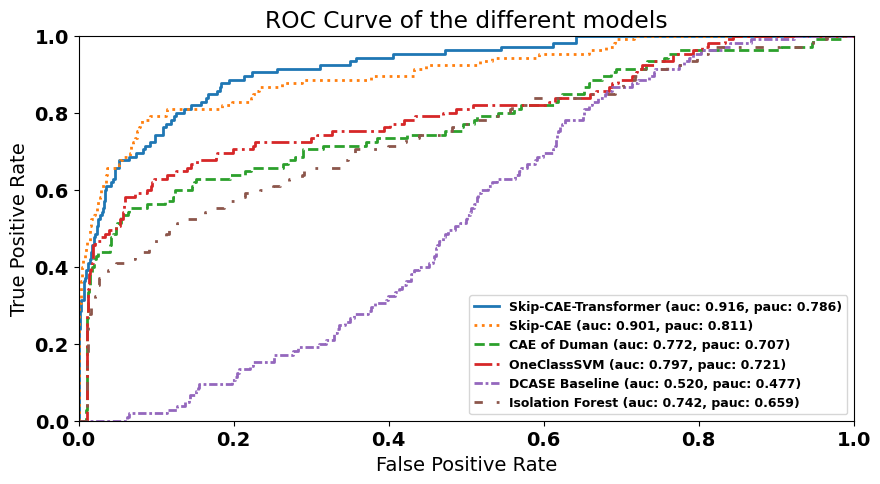

In [3]:
if not train:
    font = {'family': 'normal',
            'weight': 'bold',
            'size': 14}

    matplotlib.rc('font', **font)

    print("Generating ROC curves")
    plt.figure(figsize=(10, 5))
    for legend, scores, line in [
        ("Skip-CAE-Transformer", losses_transformer, 'solid'),
        ("Skip-CAE", losses_cae_skip, 'dotted'),
        ("CAE of Duman", losses_cae, 'dashed'),
        ("OneClassSVM", one_class_scores, 'dashdot'),
        ("DCASE Baseline", losses_ae, (0, (3, 1, 1, 1))),
        ("Isolation Forest", isolation_forest_scores, (0, (3, 5, 1, 5))),
    ]:
        fpr, tpr, thresholds = roc_curve(y_true, scores)
        roc_auc = metrics.auc(fpr, tpr)
        roc_pauc = metrics.roc_auc_score(y_true, scores, max_fpr=0.1)
        print(f'roc_auc of {legend}= ', roc_auc)
        print(f'roc_pauc of {legend}= ', roc_pauc)

        plt.plot(fpr, tpr, label=f"{legend} (auc: %0.3f, pauc: %0.3f)" % (roc_auc, roc_pauc),
                 linewidth=2.0, linestyle=line)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve of the different models')
    plt.legend(loc="lower right", prop={'size': 9})
    plt.show()

